In [7]:
from pyproj import datadir

datadir.set_data_dir("/opt/homebrew/opt/proj/share/proj")

POLYGON ((-89.86235099999999 41.584005, -89.78549 41.584213999999996, -89.74708799999999 41.584466, -89.74489299999999 41.58451, -89.679441 41.584773999999996, -89.63149399999999 41.584948999999995, -89.628371 41.585014, -89.61868 41.585049, -89.531719 41.585056, -89.516081 41.585027, -89.51261799999999 41.585065, -89.400868 41.584925999999996, -89.394757 41.584951, -89.39354 41.584921, -89.39122499999999 41.584927, -89.37191899999999 41.584978, -89.347365 41.584997, -89.347366 41.584942, -89.309817 41.585021999999995, -89.285614 41.585035999999995, -89.276918 41.585121, -89.256536 41.585229999999996, -89.223377 41.585322999999995, -89.21961 41.585164, -89.19322199999999 41.585178, -89.190454 41.585346, -89.166561 41.585288999999996, -89.166986 41.614644, -89.16703 41.617888, -89.16720000000001 41.628707, -89.129243 41.627949, -89.109873 41.627584, -89.052011 41.626704, -89.005241 41.62737, -88.968204 41.627876, -88.93861799999999 41.628319, -88.93875 41.638047, -88.939229 41.657072, -

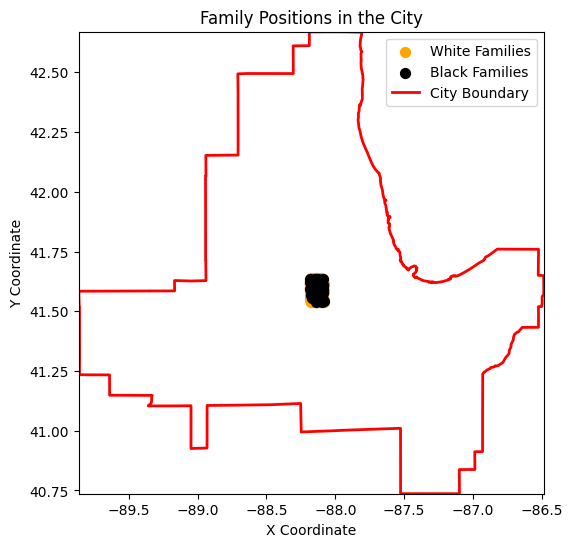

location of family -88.10241271706751, 41.63635659500589
change of family 11.401342788072382, -16.90772118584883
location of family -88.1104302174751, 41.54365559865466
change of family -3.2531422389550193, 24.855847431415093
location of family -88.18295415537463, 41.56399269445166
change of family -22.400263458855004, -1.0482993158758724
location of family -88.1589238299403, 41.58746081649854
change of family -14.466292751418319, -25.237110343888705
location of family -88.08744367516822, 41.618326291028865
change of family -3.744454550064591, 11.882684319952807
location of family -88.13872416076714, 41.58124714155683
change of family 40.539089416832894, 23.588085783966772
location of family -88.1015558279211, 41.629708311956286
change of family -32.538926115099876, 56.247308694238285
location of family -88.14068704340245, 41.636979834288255
change of family -107.03686290946894, 213.7059603267259
location of family -88.18069322003431, 41.60229517399946
change of family -15.780366581682

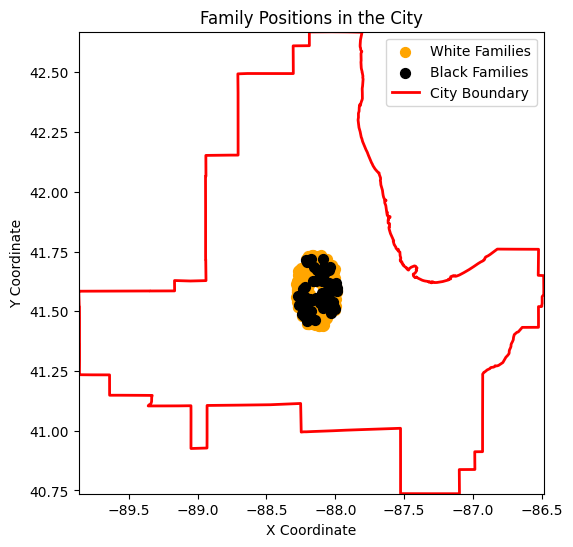

location of family -88.04650373754235, 41.553445883946004
change of family 5.7882658299793945, -7.4403781265595805
location of family -88.12340757641542, 41.642809963938966
change of family 0.5769185176956962, -0.11085245581251171
location of family -88.28284482981488, 41.55931795810892
change of family -5.114213821728943, -0.6996198678591031
location of family -88.2086545210634, 41.500703347883906
change of family -0.7061963147307765, 1.238303656769025
location of family -88.11749862074791, 41.71370291419304
change of family -1.5338728876435013, -0.6535445078869835
location of family -88.05229090855904, 41.63153921759999
change of family -0.8794185906943155, 4.306511516162019
location of family -88.1516302856804, 41.716267821428744
change of family -3.2553932602568425, 24.271102888215548
location of family -88.18546993977334, 41.72639175850775
change of family 22.336338843165922, -19.161708373701135
location of family -88.26716038289956, 41.65252892506421
change of family 2.8069930855

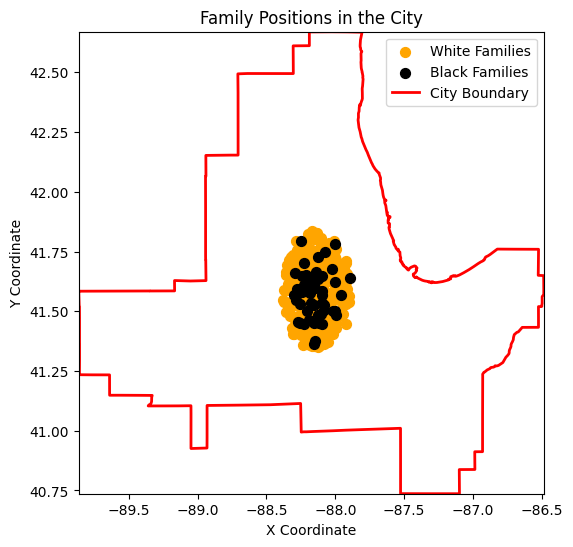

In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
import pyproj


class Family:
    def __init__(self, race, x, y):
        self.race = race
        self.x = x
        self.y = y

class StochasticVectorField2D:
    def __init__(self, city, family):
        self.city = city
        self.family = family

    def compute_vector(self):
        vector = np.array([0.0, 0.0])
        for f in self.city.families.values():
            if f == self.family:
                continue

            # Find direction and distance to other families
            direction = np.array([f.x - self.family.x, f.y - self.family.y])
            distance = np.linalg.norm(direction)
            if distance == 0:  # Avoid division by zero
                continue
            direction = direction / distance

            # Inverse square law for stronger effects
            effect = 1.0 / (distance**2 + 1e-6)

            # Apply different rules based race
            if (f.race == "black" and self.family.race == "white"):
                vector -= 0.001 * effect * direction  # Weak repulsion
            if (f.race == "white" and self.family.race == "white"):
                vector += 0.0001 * effect * direction  # Weak attraction

            if (f.race == "black" and self.family.race == "black"):
                vector += 0.0000  # Neutral to other black families
            if (f.race == "white" and self.family.race == "black"):
                vector += 0.00005 * effect * direction  # Weak attraction to white families

            # Add noise for more realistic movement
            vector += np.random.normal(0, 0.05, 2)  # Lower noise
        
        # add small bias to move towards the center TODO: Check to see if thus is the correct way to do this
        # TODO: review if needed in model
        center = self.city.city_boundary.centroid
        center_x, center_y = center.x, center.y
        
        direction = np.array([center_x - self.family.x, center_y - self.family.y])
        distance = np.linalg.norm(direction)
        if distance == 0:  # Avoid division by zero
            return vector
        direction = direction / distance

        effect = 1.0 / (distance**2 + 1e-6)
        vector += 0.001 * effect * direction

        return vector

class City:
    def __init__(self, wp, bp, city_boundary, min_distance=1.0, max_step_size=0.1):
        self.wp = wp
        self.bp = bp
        self.families = {}
        self.city_boundary = city_boundary  # Polygon representing the city boundary
        self.min_distance = min_distance  # Minimum distance constraint
        self.max_step_size = max_step_size  # Maximum step size constraint

    def populate(self):
        # Get the centroid of the city (polygon)
        centroid = self.city_boundary.centroid
        center_x, center_y = centroid.x, centroid.y

        # Populate white families around the center
        for i in range(self.wp):
            id = f"w{i}"
            x, y = self.random_position_near_center(center_x, center_y)
            family = Family("white", x, y)
            self.families[id] = family

        # Populate black families around the center
        for i in range(self.bp):
            id = f"b{i}"
            x, y = self.random_position_near_center(center_x, center_y)
            family = Family("black", x, y)
            self.families[id] = family

    def random_position_near_center(self, center_x, center_y):
        """Generate a random position near the center within the city boundary."""
        while True:
            # Generate random x, y coordinates near the centroid
            x_offset = random.uniform(-0.05, 0.05)  # Spread out by a small random amount
            y_offset = random.uniform(-0.05, 0.05)  # Spread out by a small random amount
            x = center_x + x_offset
            y = center_y + y_offset
            point = Point(x, y)
            print(f"point {point}")
            # Check if the generated point is inside the boundary
            if self.city_boundary.contains(point):
                return x, y

    def is_too_close(self, family, new_x, new_y):
        """Check if the new position is too close to any other family."""
        for other in self.families.values():
            if other == family:
                continue
            distance = np.linalg.norm([new_x - other.x, new_y - other.y])
            if distance < self.min_distance:
                return True
        return False

    def step(self):
        # Update positions based on vector field
        for family in self.families.values():
            print(f"location of family {family.x}, {family.y}")
            vf = StochasticVectorField2D(self, family)
            vector = vf.compute_vector()
            print(f"change of family {vector[0]}, {vector[1]}")
            
            # Propose new position
            new_x = family.x + vector[0]
            new_y = family.y + vector[1]

            # Limit the movement (capping the maximum step size)
            distance = np.linalg.norm([new_x - family.x, new_y - family.y])
            if distance > self.max_step_size:
                # Scale the vector to the maximum step size
                scale_factor = self.max_step_size / distance
                new_x = family.x + vector[0] * scale_factor
                new_y = family.y + vector[1] * scale_factor

            # Check if the new position is too close to other families
            if not self.is_too_close(family, new_x, new_y):
                # Adjust the movement to stay within bounds
                if not self.city_boundary.contains(Point(new_x, new_y)):
                    # Calculate the best fitting vector that stays inside the boundary
                    new_x, new_y = self.keep_within_bounds(new_x, new_y)
                family.x = new_x
                family.y = new_y

            # Optional: Ensure positions stay within grid bounds
            family.x = np.clip(family.x, self.city_boundary.bounds[0], self.city_boundary.bounds[2])
            family.y = np.clip(family.y, self.city_boundary.bounds[1], self.city_boundary.bounds[3])

        # Plot the city grid with families
        self.plot_grid()

    def keep_within_bounds(self, new_x, new_y):
        # Ensure the new position is within the city boundary
        point = Point(new_x, new_y)
        if self.city_boundary.contains(point):
            return new_x, new_y
        else:
            # Use nearest_points to find the closest point on the boundary
            nearest_point = nearest_points(point, self.city_boundary.boundary)[1]
            return nearest_point.x, nearest_point.y

    def plot_grid(self):
        # Plot family positions using scatter
        plt.figure(figsize=(6, 6))
        white_x = []
        white_y = []
        black_x = []
        black_y = []

        # Separate families by race
        for family in self.families.values():
            if family.race == "white":
                white_x.append(family.x)
                white_y.append(family.y)
            else:
                black_x.append(family.x)
                black_y.append(family.y)

        # Plot the positions with specified colors
        plt.scatter(white_x, white_y, color='orange', label="White Families", s=50)
        plt.scatter(black_x, black_y, color='black', label="Black Families", s=50)

        # Plot the city boundary (polygon)
        x, y = self.city_boundary.exterior.xy
        plt.plot(x, y, color='red', linewidth=2, label="City Boundary")

        # Set grid limits and labels
        plt.xlim(self.city_boundary.bounds[0], self.city_boundary.bounds[2])
        plt.ylim(self.city_boundary.bounds[1], self.city_boundary.bounds[3])
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.title('Family Positions in the City')
        plt.legend()

        # Show the plot
        plt.show()


# Read the shapefile for the city boundary (make sure to adjust the file path)
shapefile_path = "ex_gis/cb_2018_us_csa_500k.shp"
pyproj.datadir.set_data_dir("/opt/homebrew/opt/proj/share/proj")
gdf = gpd.read_file(shapefile_path)

# Assume you want to use the first polygon as the city boundary
city_boundary = gdf.geometry.iloc[49]
print(city_boundary)

# Simulation
white_population = 400
black_population = 50
min_distance = 0  # Minimum distance between families

city = City(white_population, black_population, city_boundary, min_distance)
city.populate()
city.plot_grid()

# Run simulation for a few steps
for _ in range(2):
    city.step()

In [ ]:
# find chicago in the shapefile, name has regex Chicago
chicago = gdf[gdf['NAME'].str.contains('Chicago', case=False)]
chicago

In [175]:
# select name column from gdf
gdf['NAME'].values

array(['Gainesville-Lake City, FL', 'Indianapolis-Carmel-Muncie, IN',
       'Tulsa-Muskogee-Bartlesville, OK', 'Houston-The Woodlands, TX',
       'Savannah-Hinesville-Statesboro, GA',
       'Rocky Mount-Wilson-Roanoke Rapids, NC', 'Pueblo-Cañon City, CO',
       'Youngstown-Warren, OH-PA', 'Greenville-Spartanburg-Anderson, SC',
       'Dixon-Sterling, IL', 'Cleveland-Indianola, MS',
       'Dayton-Springfield-Sidney, OH', 'Birmingham-Hoover-Talladega, AL',
       'Parkersburg-Marietta-Vienna, WV-OH',
       'Brownsville-Harlingen-Raymondville, TX',
       'Milwaukee-Racine-Waukesha, WI', 'North Port-Sarasota, FL',
       'Los Angeles-Long Beach, CA', 'Columbia-Moberly-Mexico, MO',
       'Buffalo-Cheektowaga, NY', 'Johnson City-Kingsport-Bristol, TN-VA',
       'Dothan-Enterprise-Ozark, AL',
       'Atlanta--Athens-Clarke County--Sandy Springs, GA',
       'Bowling Green-Glasgow, KY', 'Dallas-Fort Worth, TX-OK',
       'Kansas City-Overland Park-Kansas City, MO-KS',
       'Oklahoma